<a href="https://colab.research.google.com/github/ashithapallath/Computational-Linguistics/blob/main/CL_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 1.Implement a simple rule-based Text tokenizer for the English language using regular expressions. Your tokenizer should consider punctuations and special symbols as separate tokens. Contractions like "isn't" should be regarded as 2 tokens - "is" and "n't". Also identify abbreviations (eg, U.S.A) and internal hyphenation (eg. ice-cream), as single tokens. draft a python code for this give explanation of the code also

In [ ]:
def tokenizeText(text):
    pattern = r"""
    (?:[A-Za-z]\.){2,}[A-Z]  # Matches abbreviations like U.S.A or U.K
    | \w+(?:-\w+)+            # Matches hyphenated words like ice-cream
    | \b([A-Za-z]+)(n't|'s|'ll|'em|'ve|'re|'d)\b # Matches contractions like isn't, you'll
    | \b\w+\b    # Matches standalone words
    | [.,!?;"()\[\]{}<>] # Matches punctuation as separate tokens
    """
    tokens = []
    for match in re.finditer(pattern, text, flags=re.VERBOSE):
        if match.group(1):
            tokens.extend([match.group(1), match.group(2)])
        else:
            tokens.append(match.group(0))
    return tokens

text = 'Implement a simple rule-based Text tokenizer for the English language using regular expressions. Your tokenizer should consider punctuations and special symbols as separate tokens. Contractions like "isn\'t" should be regarded as 2 tokens - "is" and "n\'t". Also identify abbreviations (eg, U.S.A) and internal hyphenation (eg. ice-cream), as single tokens.'
tokens = tokenizeText(text)
tokens = set(tokens)
print(tokens)

{'hyphenation', 'single', '.', 'Implement', 'should', 'identify', 'symbols', 'U.S.A', ',', 'using', 'Your', '2', 'Contractions', 'be', ')', 'for', 'regarded', 'tokens', 'rule-based', 'special', 'separate', 'abbreviations', 'like', 'simple', 'a', 't', 'regular', 'the', '"', '(', 'punctuations', 'as', 'English', 'is', 'internal', 'ice-cream', 'n', "n't", 'Text', 'Also', 'language', 'tokenizer', 'consider', 'and', 'e.g.', 'expressions'}


2.Design and implement a Finite State Automata(FSA) that accepts English plural nouns ending with the character ‘y’, e.g. boys, toys, ponies, skies, and puppies but not boies or toies or ponys. (Hint: Words that end with a vowel followed by ‘y’ are appended with ‘s'
                 and will not be replaced with “ies” in their plural form).


{'boys': True, 'toys': True, 'ponies': True, 'skies': True, 'puppies': True, 'boies': False, 'toies': False, 'ponys': False, 'Babbies': True}


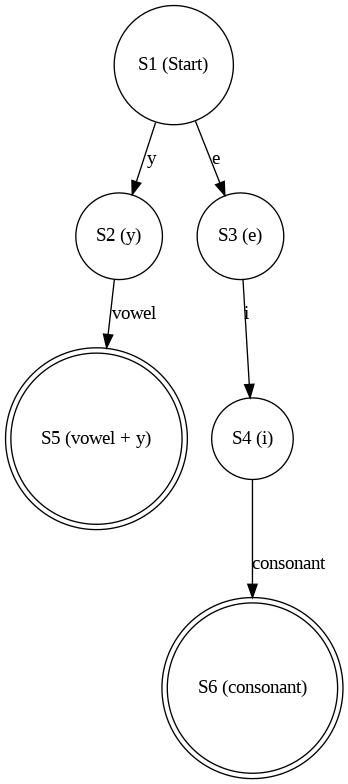

In [ ]:
import graphviz

def is_plural_noun_accepted_fsa(word):
    # Check if the word is at least 2 characters long and ends with 's'
    if len(word) < 2 or word[-1] != 's':
        return False

    # Reverse the word for easier state processing
    word = word[::-1]
    state = 'S1'  # Initial state

    for char in word[1:]:  # Skip the last character ('s')
        if state == 'S1':
            if char == 'y':
                state = 'S2'  # Transition to state for vowel + 'y'
            elif char == 'e':
                state = 'S3'  # Transition to state for 'ies'
            else:
                return False  # Invalid transition

        elif state == 'S2':
            if char in 'aeiou':
                state = 'S5'  # Valid transition to vowel + 'y' state
            else:
                return False  # Invalid transition

        elif state == 'S3':
            if char == 'i':
                state = 'S4'  # Valid transition to state for 'ies'
            else:
                return False  # Invalid transition

        elif state == 'S4':
            if char.isalpha() and char not in 'aeiou':
                state = 'S6'  # Transition to final state after consonant
            else:
                return False  # Invalid transition

        # States S5 and S6 indicate acceptance; continue checking
        elif state in ('S5', 'S6'):
            continue

    return True  # If we reach here, the word is a valid plural noun

def draw_fsa():
    dot = graphviz.Digraph(comment='FSA for Plural Noun Detection')

    # Define states
    dot.node('S1', 'S1 (Start)', shape='circle')  # Start state
    dot.node('S2', 'S2 (y)', shape='circle')
    dot.node('S3', 'S3 (e)', shape='circle')
    dot.node('S4', 'S4 (i)', shape='circle')
    dot.node('S5', 'S5 (vowel + y)', shape='doublecircle')  # Accepting state
    dot.node('S6', 'S6 (consonant)', shape='doublecircle')  # Accepting state

    # Define transitions
    dot.edge('S1', 'S2', "y")
    dot.edge('S1', 'S3', "e")
    dot.edge('S2', 'S5', "vowel")
    dot.edge('S3', 'S4', "i")
    dot.edge('S4', 'S6', "consonant")

    return dot

# Test cases
test_words = ['boys', 'toys', 'ponies', 'skies', 'puppies', 'boies', 'toies', 'ponys', "Babbies"]
results = {word: is_plural_noun_accepted_fsa(word) for word in test_words}
print(results)

# Draw and render the FSA
fsa_graph = draw_fsa()
fsa_graph.render('plural_noun_fsa', format='png', cleanup=True)

# Display the generated FSA diagram in a Jupyter Notebook (if using one)
from IPython.display import Image
Image('plural_noun_fsa.png')


3.Design and implement a Finite State Transducer(FST) that accepts lexical forms of
English words(e.g. shown below) and generates its corresponding plurals, based on the
e-insertion spelling rule є => e / {x,s,z}^ __ s#
^ is the morpheme boundary and # - word boundary

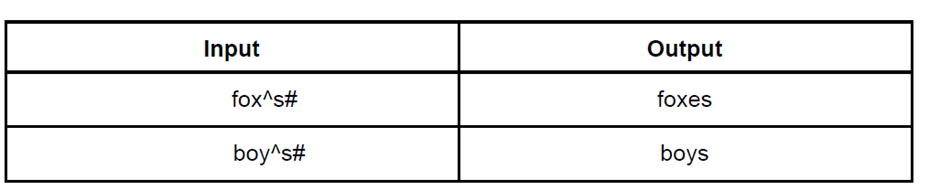

{'fox^s#': 'foxes', 'boy^s#': 'boys', 'bus^s#': 'buses', 'dog^s#': 'dogs', 'box^s#': 'boxes'}


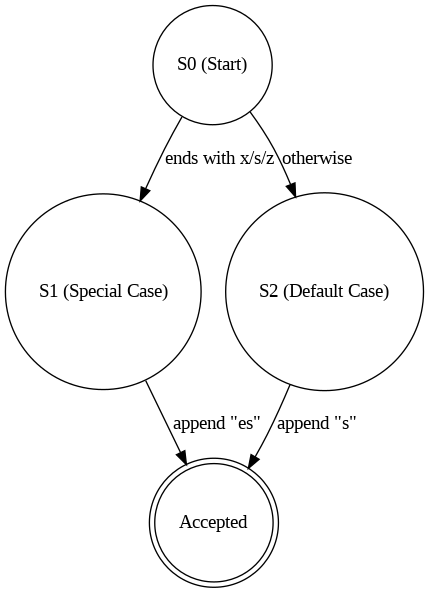

In [1]:
import graphviz

def generate_plural_fst(word):
    # Start in State 0
    state = 0

    # Transition logic based on states
    if state == 0:
        # Check for special cases requiring 'es'
        if word.endswith("^s#"):
            # Remove the suffix for processing
            base_word = word[:-3]

            # Check if the base word ends with special cases for pluralization
            if base_word.endswith(("x", "s", "z", "ch", "sh")):
                # Transition to plural form with 'es'
                return base_word + "es"
            else:
                # Default case: pluralize with 's'
                return base_word + "s"

    # If no rules apply, return the original word
    return word

def draw_fst():
    dot = graphviz.Digraph(comment='FST for Plural Generation')

    # Define states
    dot.node('S0', 'S0 (Start)', shape='circle')  # Start state
    dot.node('S1', 'S1 (Special Case)', shape='circle')
    dot.node('S2', 'S2 (Default Case)', shape='circle')
    dot.node('Accept', 'Accepted', shape='doublecircle')  # Only final state as double circle

    # Define transitions
    dot.edge('S0', 'S1', 'ends with x/s/z')
    dot.edge('S1', 'Accept', 'append "es"')
    dot.edge('S0', 'S2', 'otherwise')
    dot.edge('S2', 'Accept', 'append "s"')

    return dot

# Test cases to check plural generation
test_cases = ["fox^s#", "boy^s#", "bus^s#", "dog^s#", "box^s#"]
# Dictionary to store results for each test case
plural_forms = {word: generate_plural_fst(word) for word in test_cases}

print(plural_forms)

# Draw and render the FST
fst_graph = draw_fst()
fst_graph.render('plural_generation_fst', format='png', cleanup=True)

# Display the generated FST diagram
from IPython.display import Image
Image('plural_generation_fst.png')


4.Implement the Minimum Edit Distance algorithm to find the edit distance between any
           two given strings. Also, list the edit operations.



In [2]:
import numpy as np

def edit_distance(source, target):
    """
    Calculate the edit distance between source and target strings,
    and return the operations to convert source to target.
    """
    # Initialize dimensions
    len_source = len(source)
    len_target = len(target)

    # Initialize distance table
    distance_table = np.zeros((len_source + 1, len_target + 1), dtype=int)

    # Fill base cases
    for i in range(len_source + 1):
        distance_table[i][0] = i
    for j in range(len_target + 1):
        distance_table[0][j] = j

    # Fill distance table with dynamic programming
    for i in range(1, len_source + 1):
        for j in range(1, len_target + 1):
            if source[i - 1] == target[j - 1]:
                distance_table[i][j] = distance_table[i - 1][j - 1]
            else:
                distance_table[i][j] = min(
                    distance_table[i][j - 1] + 1,             # Insertion
                    distance_table[i - 1][j] + 1,             # Deletion
                    distance_table[i - 1][j - 1] + 2          # Substitution
                )

    # Trace back to determine operations
    operations = []
    i, j = len_source, len_target
    while i > 0 or j > 0:
        if i > 0 and j > 0 and source[i - 1] == target[j - 1]:
            i, j = i - 1, j - 1
        elif i > 0 and distance_table[i][j] == distance_table[i - 1][j] + 1:
            operations.append(f"Delete '{source[i - 1]}' from position {i}")
            i -= 1
        elif j > 0 and distance_table[i][j] == distance_table[i][j - 1] + 1:
            operations.append(f"Insert '{target[j - 1]}' at position {j}")
            j -= 1
        else:
            operations.append(f"Substitute '{source[i - 1]}' with '{target[j - 1]}' at position {i}")
            i, j = i - 1, j - 1

    # Reverse operations for correct order
    operations.reverse()
    return distance_table[len_source][len_target], operations

# Test the function with sample input
source = "exclusive"
target = "inclusive"
distance, operations = edit_distance(source, target)
print("Edit Distance:", distance)
print("Operations:")
for operation in operations:
    print(operation)


Edit Distance: 4
Operations:
Insert 'i' at position 1
Insert 'n' at position 2
Delete 'e' from position 1
Delete 'x' from position 2


5.Design and implement a statistical spell checker for detecting and correcting non-word
spelling errors in English, using the bigram language model. Your program should do the
following:

a. Tokenize the corpus and create a vocabulary of unique words.

b. Create a bi-gram frequency table for all possible bigrams in the corpus.

c. Scan the given input text to identify the non-word spelling errors

d. Generate the candidate list using 1 edit distance from the misspelled words

e. Suggest the best candidate word by calculating the probability of the given sentence using the bigram LM.

6.Implement a text classifier for sentiment analysis using the Naive Bayes theorem. Use
Add-k smoothing to handle zero probabilities. Compare the performance of your classifier for k values 0.25, 0.75, and 1.

In [20]:
import re
from collections import defaultdict

def tokenize(text):
    # Tokenize text into words using regex for simplicity
    return re.findall(r'\b\w+\b', text.lower())

def build_vocabulary_and_bigrams(corpus):
    words = tokenize(corpus)
    vocabulary = set(words)

    bigram_freq = defaultdict(int)
    for i in range(len(words) - 1):
        bigram = (words[i], words[i+1])
        bigram_freq[bigram] += 1

    print("Vocabulary:", vocabulary)  # Print the vocabulary
    print("Bigram Frequency Table:", dict(bigram_freq))  # Print bigram frequency table

    return vocabulary, bigram_freq

def find_misspellings(text, vocabulary):
    words = tokenize(text)
    misspellings = [word for word in words if word not in vocabulary]
    print("Identified Misspellings:", misspellings)  # Print identified misspellings
    return misspellings

def edits1(word):
    # Generate all words one edit away from `word`
    letters = 'abcdefghijklmnopqrstuvwxyz'
    splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    deletes = [L + R[1:] for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R) > 1]
    replaces = [L + c + R[1:] for L, R in splits if R for c in letters]
    inserts = [L + c + R for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def get_candidates(word, vocabulary):
    # Get candidate corrections for the misspelled word
    candidates = {w for w in edits1(word) if w in vocabulary}
    print(f"Candidates for '{word}':", candidates)  # Print candidate corrections
    return candidates

def get_multigram_candidates(misspelled_word, words, vocabulary):
    # Generate multi-word candidates by combining single-word candidates
    candidates = set()
    for i in range(len(words)):
        for j in range(i + 1, len(words) + 1):
            candidate = ' '.join(words[i:j])
            if candidate in vocabulary:
                candidates.add(candidate)
    return candidates

def bigram_probability(sentence, bigram_freq):
    words = tokenize(sentence)
    bigram_prob = 1.0
    for i in range(len(words) - 1):
        bigram = (words[i], words[i+1])
        # Add a small constant to avoid zero probability
        bigram_prob *= (bigram_freq[bigram] + 1) / sum(bigram_freq.values())
    return bigram_prob

def correct_spelling(text, vocabulary, bigram_freq):
    words = tokenize(text)
    misspellings = find_misspellings(text, vocabulary)

    corrected_text = words[:]

    for misspelled_word in misspellings:
        candidates = get_candidates(misspelled_word, vocabulary)
        multi_candidates = get_multigram_candidates(misspelled_word, words, vocabulary)

        # Combine single-word and multi-word candidates
        all_candidates = candidates.union(multi_candidates)

        if all_candidates:
            best_candidate = max(
                all_candidates,
                key=lambda candidate: bigram_probability(
                    ' '.join(words).replace(misspelled_word, candidate), bigram_freq
                )
            )
            print(f"Replacing '{misspelled_word}' with '{best_candidate}'")  # Print replacement info
            corrected_text = [best_candidate if w == misspelled_word else w for w in corrected_text]

    return ' '.join(corrected_text)

# Example corpus and test case
corpus = (
    "Knowledge is power. The pen is mightier than the sword. Actions speak louder than "
    "words. Practice makes perfect. Better late than never. Birds of a feather flock together. "
    "A picture is worth a thousand words. When the going gets tough, the tough get going. "
    "Fortune favors the bold. Honesty is the best policy. Every cloud has a silver lining."
)

# Corrected multi-line string
input_text = (
    "Knwledge is powr. The pen is mighter than the sord. Practce makes prfect. "
    "A picure is worth a tousand words."
)

# Building vocabulary and bigram frequency table
vocabulary, bigram_freq = build_vocabulary_and_bigrams(corpus)

# Correct the input text
corrected_text = correct_spelling(input_text, vocabulary, bigram_freq)
print("Corrected Text:", corrected_text)


Vocabulary: {'flock', 'together', 'worth', 'sword', 'best', 'every', 'speak', 'practice', 'silver', 'policy', 'fortune', 'perfect', 'is', 'the', 'words', 'actions', 'honesty', 'has', 'a', 'mightier', 'never', 'feather', 'of', 'birds', 'bold', 'lining', 'thousand', 'late', 'picture', 'louder', 'gets', 'better', 'favors', 'tough', 'get', 'knowledge', 'pen', 'power', 'than', 'cloud', 'when', 'going', 'makes'}
Bigram Frequency Table: {('knowledge', 'is'): 1, ('is', 'power'): 1, ('power', 'the'): 1, ('the', 'pen'): 1, ('pen', 'is'): 1, ('is', 'mightier'): 1, ('mightier', 'than'): 1, ('than', 'the'): 1, ('the', 'sword'): 1, ('sword', 'actions'): 1, ('actions', 'speak'): 1, ('speak', 'louder'): 1, ('louder', 'than'): 1, ('than', 'words'): 1, ('words', 'practice'): 1, ('practice', 'makes'): 1, ('makes', 'perfect'): 1, ('perfect', 'better'): 1, ('better', 'late'): 1, ('late', 'than'): 1, ('than', 'never'): 1, ('never', 'birds'): 1, ('birds', 'of'): 1, ('of', 'a'): 1, ('a', 'feather'): 1, ('feat

In [ ]:
!pip install numpy pandas scikit-learn nltk


In [18]:
import nltk
nltk.download('movie_reviews')
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import movie_reviews

# Load positive and negative reviews
positive_fileids = movie_reviews.fileids('pos')
negative_fileids = movie_reviews.fileids('neg')

documents = [(movie_reviews.raw(fileid), 'pos') for fileid in positive_fileids]
documents.extend([(movie_reviews.raw(fileid), 'neg') for fileid in negative_fileids])

# Create DataFrame
df = pd.DataFrame(documents, columns=['text', 'label'])

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Vectorize text data
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Define Naive Bayes classifier
class NaiveBayes:
    def __init__(self, k=1):
        self.k = k

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.class_counts = {c: 0 for c in self.classes}
        self.feature_counts = {c: np.zeros(X.shape[1]) for c in self.classes}

        for i, c in enumerate(y):
            self.class_counts[c] += 1
            self.feature_counts[c] += X[i].toarray()[0]

        self.total_documents = len(y)
        self.vocab_size = X.shape[1]

    def predict(self, X):
        predictions = []
        for i in range(X.shape[0]):
            post_probs = {}
            for c in self.classes:
                class_prob = (self.class_counts[c] + self.k) / (self.total_documents + self.k * len(self.classes))
                feature_prob = np.sum((X[i].toarray()[0] + self.k) / (self.feature_counts[c] + self.k * self.vocab_size))
                post_probs[c] = class_prob * feature_prob

            predictions.append(max(post_probs, key=post_probs.get))
        return np.array(predictions)

# Train and evaluate the model with different smoothing parameters
k_values = [0.25, 0.75, 1]
results = {}

for k in k_values:
    model = NaiveBayes(k=k)
    model.fit(X_train_vectorized, y_train)
    y_pred = model.predict(X_test_vectorized)

    accuracy = accuracy_score(y_test, y_pred)
    results[k] = accuracy
    print(f"Accuracy for k={k}: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))


[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


Accuracy for k=0.25: 0.4950
              precision    recall  f1-score   support

         neg       0.00      0.00      0.00       201
         pos       0.50      0.99      0.66       199

    accuracy                           0.49       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.49      0.33       400

Accuracy for k=0.75: 0.4975
              precision    recall  f1-score   support

         neg       0.00      0.00      0.00       201
         pos       0.50      1.00      0.66       199

    accuracy                           0.50       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.50      0.33       400



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy for k=1: 0.4975
              precision    recall  f1-score   support

         neg       0.00      0.00      0.00       201
         pos       0.50      1.00      0.66       199

    accuracy                           0.50       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.50      0.33       400



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [5]:
import numpy as np

def viterbi_algorithm(sentence, states, start_probabilities, transition_probs, emission_probs):
    # Initialize the matrices
    num_states = len(states)
    num_words = len(sentence)

    viterbi = np.zeros((num_states, num_words))
    backtrack = np.zeros((num_states, num_words), dtype=int)

    # Initialization step
    for state_index, state in enumerate(states):
        viterbi[state_index, 0] = start_probabilities.get(state, 0) * emission_probs.get(state, {}).get(sentence[0], 0)

    # Recursion step
    for t in range(1, num_words):
        for current_state_index, current_state in enumerate(states):
            max_prob = 0
            prev_state_index = 0

            for previous_state_index, previous_state in enumerate(states):
                prob = (
                    viterbi[previous_state_index, t - 1]
                    * transition_probs.get(previous_state, {}).get(current_state, 0)
                    * emission_probs.get(current_state, {}).get(sentence[t], 0)
                )
                if prob > max_prob:
                    max_prob = prob
                    prev_state_index = previous_state_index

            viterbi[current_state_index, t] = max_prob
            backtrack[current_state_index, t] = prev_state_index

    # Termination step
    final_prob = np.max(viterbi[:, -1])
    final_state_index = np.argmax(viterbi[:, -1])

    # Backtracking to find the best path
    best_sequence = []
    for t in range(num_words - 1, -1, -1):
        best_sequence.insert(0, states[final_state_index])
        final_state_index = backtrack[final_state_index, t]

    return best_sequence, final_prob

# Example input data
states = ['NN', 'VB', 'JJ', 'RB']
sentence = ["time", "flies", "fast"]
start_probabilities = {'NN': 0.5, 'VB': 0.25, 'JJ': 0.25, 'RB': 0}
transition_probabilities = {
    'START': {'NN': 0.5, 'VB': 0.25, 'JJ': 0.25, 'RB': 0},
    'NN': {'NN': 0.25, 'VB': 0.5, 'JJ': 0, 'RB': 0},
    'VB': {'NN': 0.25, 'VB': 0.25, 'JJ': 0.25, 'RB': 0.25},
    'JJ': {'NN': 0.75, 'VB': 0, 'JJ': 0.25, 'RB': 0},
    'RB': {'NN': 0.25, 'VB': 0.25, 'JJ': 0, 'RB': 0.5},
}
emission_probabilities = {
    'NN': {'time': 0.1, 'flies': 0.01, 'fast': 0.01},
    'VB': {'time': 0.01, 'flies': 0.1, 'fast': 0.01},
    'JJ': {'time': 0, 'flies': 0, 'fast': 0.1},
    'RB': {'time': 0, 'flies': 0, 'fast': 0.1},
}

# Run the algorithm
best_sequence, best_probability = viterbi_algorithm(
    sentence, states, start_probabilities, transition_probabilities, emission_probabilities
)

# Print results

print(f"Input Sentence: {' '.join(sentence)}")
print(f"Best POS Tag Sequence: {' -> '.join(best_sequence)}")
print(f"Probability of the Best Sequence: {best_probability:.10f}")



Input Sentence: time flies fast
Best POS Tag Sequence: NN -> VB -> JJ
Probability of the Best Sequence: 0.0000625000


In [7]:
from collections import defaultdict
import math

def compute_bigrams(corpus):
    tokens = corpus.split()  # Tokenize the text into words
    unigram_counts = defaultdict(int)
    bigram_counts = defaultdict(int)

    # Count unigrams and bigrams
    for idx in range(len(tokens)):
        unigram_counts[tokens[idx]] += 1
        if idx < len(tokens) - 1:
            bigram_counts[(tokens[idx], tokens[idx + 1])] += 1

    # Calculate bigram probabilities
    bigram_probs = {}
    for bigram, count in bigram_counts.items():
        bigram_probs[bigram] = count / unigram_counts[bigram[0]]

    return unigram_counts, bigram_counts, bigram_probs

def compute_sentence_probability(sentence, bigram_probs):
    words = sentence.split()
    probability = 1.0

    for idx in range(len(words) - 1):
        bigram = (words[idx], words[idx + 1])
        if bigram in bigram_probs:
            probability *= bigram_probs[bigram]
        else:
            probability *= 0.0001  # Assign small probability for unseen bigrams

    return probability

# Sample corpus and sentence
dataset = (
    "the quick brown fox jumps over the lazy dog "
    "a quick brown dog outpaces a quick fox"
)
input_text = "the quick brown fox jumps"

# Compute probabilities
unigrams, bigrams, probabilities = compute_bigrams(dataset)
text_probability = compute_sentence_probability(input_text, probabilities)

# Display results
print("Unigram Counts:", dict(unigrams))
print("\nBigram Counts:", dict(bigrams))
print("\nBigram Probabilities:", {k: round(v, 6) for k, v in probabilities.items()})
print(f"\nProbability of the sentence '{input_text}': {text_probability:.10f}")


Unigram Counts: {'the': 2, 'quick': 3, 'brown': 2, 'fox': 2, 'jumps': 1, 'over': 1, 'lazy': 1, 'dog': 2, 'a': 2, 'outpaces': 1}

Bigram Counts: {('the', 'quick'): 1, ('quick', 'brown'): 2, ('brown', 'fox'): 1, ('fox', 'jumps'): 1, ('jumps', 'over'): 1, ('over', 'the'): 1, ('the', 'lazy'): 1, ('lazy', 'dog'): 1, ('dog', 'a'): 1, ('a', 'quick'): 2, ('brown', 'dog'): 1, ('dog', 'outpaces'): 1, ('outpaces', 'a'): 1, ('quick', 'fox'): 1}

Bigram Probabilities: {('the', 'quick'): 0.5, ('quick', 'brown'): 0.666667, ('brown', 'fox'): 0.5, ('fox', 'jumps'): 0.5, ('jumps', 'over'): 1.0, ('over', 'the'): 1.0, ('the', 'lazy'): 0.5, ('lazy', 'dog'): 1.0, ('dog', 'a'): 0.5, ('a', 'quick'): 1.0, ('brown', 'dog'): 0.5, ('dog', 'outpaces'): 0.5, ('outpaces', 'a'): 1.0, ('quick', 'fox'): 0.333333}

Probability of the sentence 'the quick brown fox jumps': 0.0833333333


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def compute_tfidf_similarity(docs):
    """Calculate TF-IDF matrix and cosine similarities."""
    # Generate the TF-IDF matrix
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(docs)

    # Compute cosine similarity between first two documents
    cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]

    return tfidf_vectorizer, tfidf_matrix, cosine_sim

def word_similarity(word1, word2, vectorizer, matrix):
    """Calculate cosine similarity between vectors of two words."""
    try:
        idx1, idx2 = vectorizer.vocabulary_[word1], vectorizer.vocabulary_[word2]
        word_vec1, word_vec2 = matrix[:, idx1].toarray().flatten(), matrix[:, idx2].toarray().flatten()
        return cosine_similarity([word_vec1], [word_vec2])[0][0]
    except KeyError:
        return 0.0  # Return zero if a word is not found in the vocabulary

# Example documents
sample_docs = [
    "time flies fast",
    "flies are flying fast",
    "fast time is good",
]

# Compute TF-IDF and similarities
vectorizer, tfidf_matrix, doc_similarity = compute_tfidf_similarity(sample_docs)
word_pair_similarity = word_similarity('time', 'flies', vectorizer, tfidf_matrix)

# Output
print("\nTF-IDF Matrix (as a Matrix):")
tfidf_matrix_array = tfidf_matrix.toarray()
terms = vectorizer.get_feature_names_out()

# Print the matrix with terms
print("      " + "  ".join(f"{term:10}" for term in terms))  # Print terms as column headers
for i, row in enumerate(tfidf_matrix_array):
    print(f"Doc {i+1}: " + "  ".join(f"{val:.4f}" for val in row))  # Print each document's vector

print("\nDocument Similarities:")
print(f"Similarity between Document 1 and Document 2: {doc_similarity:.4f}")

print("\nWord Similarities:")
print(f"Similarity between 'time' and 'flies': {word_pair_similarity:.4f}")



TF-IDF Matrix (as a Matrix):
      are         fast        flies       flying      good        is          time      
Doc 1: 0.0000  0.4813  0.6198  0.0000  0.0000  0.0000  0.6198
Doc 2: 0.5845  0.3452  0.4445  0.5845  0.0000  0.0000  0.0000
Doc 3: 0.0000  0.3452  0.0000  0.0000  0.5845  0.5845  0.4445

Document Similarities:
Similarity between Document 1 and Document 2: 0.4417

Word Similarities:
Similarity between 'time' and 'flies': 0.6603


In [11]:
import numpy as np
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

def generate_ppmi_matrix(corpus):
    """Generate PPMI matrix from a list of documents."""
    word_freq = defaultdict(int)
    co_occurrence = defaultdict(int)
    total_words = 0

    # Step 1: Calculate word frequencies and co-occurrence counts
    for sentence in corpus:
        words = sentence.split()
        total_words += len(words)
        for i, word in enumerate(words):
            word_freq[word] += 1
            for j in range(i + 1, len(words)):
                co_occurrence[(word, words[j])] += 1
                co_occurrence[(words[j], word)] += 1

    # Step 2: Build vocabulary and index
    vocabulary = sorted(word_freq.keys())
    vocab_size = len(vocabulary)
    word_to_index = {word: idx for idx, word in enumerate(vocabulary)}

    # Step 3: Create co-occurrence matrix
    co_occurrence_matrix = np.zeros((vocab_size, vocab_size))
    for (word1, word2), count in co_occurrence.items():
        idx1, idx2 = word_to_index[word1], word_to_index[word2]
        co_occurrence_matrix[idx1, idx2] = count

    # Step 4: Compute PPMI matrix
    ppmi_matrix = np.zeros_like(co_occurrence_matrix)
    for i in range(vocab_size):
        for j in range(vocab_size):
            joint_prob = co_occurrence_matrix[i, j] / total_words
            if joint_prob > 0:
                ppmi_value = np.log2(joint_prob / (word_freq[vocabulary[i]] / total_words * word_freq[vocabulary[j]] / total_words))
                ppmi_matrix[i, j] = max(0, ppmi_value)

    return ppmi_matrix, word_to_index

def calculate_cosine_similarity(matrix, vocab_index, term1, term2):
    """Calculate cosine similarity between two words based on PPMI vectors."""
    idx1, idx2 = vocab_index[term1], vocab_index[term2]
    vector1, vector2 = matrix[idx1], matrix[idx2]
    return cosine_similarity([vector1], [vector2])[0][0]

# Training corpus (documents)
documents = [
    "the quick brown fox jumps over the lazy dog",
    "the quick brown fox is very quick",
    "the lazy dog sleeps all day",
]

# Step 1: Generate PPMI matrix and word-to-index mapping
ppmi_matrix, vocab_index = generate_ppmi_matrix(documents)

# Example 1: Cosine similarity between two words
word1 = "quick"
word2 = "lazy"
similarity_between_words = calculate_cosine_similarity(ppmi_matrix, vocab_index, word1, word2)

# Step 2: Output the word similarity result
print(f"--- Word Similarity Analysis ---")
print(f"Words compared: '{word1}' and '{word2}'")
print(f"Cosine Similarity: {similarity_between_words:.4f}")
if similarity_between_words > 0.5:
    print("Interpretation: These words are quite similar in the context of the corpus.")
else:
    print("Interpretation: These words are not very similar in the context of the corpus.")

# Example 2: Cosine similarity between two documents based on PPMI vectors
doc_ppmi_vectors = np.zeros((len(documents), ppmi_matrix.shape[0]))
for doc_idx, doc in enumerate(documents):
    words = doc.split()
    for word in words:
        if word in vocab_index:
            doc_ppmi_vectors[doc_idx] += ppmi_matrix[vocab_index[word]]

# Calculate document similarity
doc_similarity = cosine_similarity([doc_ppmi_vectors[0]], [doc_ppmi_vectors[1]])[0][0]

# Step 3: Output the document similarity result
print(f"\n--- Document Similarity Analysis ---")
print(f"Documents compared: Document 1 and Document 2")
print(f"Cosine Similarity: {doc_similarity:.4f}")
if doc_similarity > 0.7:
    print("Interpretation: These documents are highly similar in terms of content and context.")
elif doc_similarity > 0.4:
    print("Interpretation: These documents share some similarities but differ in context.")
else:
    print("Interpretation: These documents are quite different from each other in terms of content.")


--- Word Similarity Analysis ---
Words compared: 'quick' and 'lazy'
Cosine Similarity: 0.6016
Interpretation: These words are quite similar in the context of the corpus.

--- Document Similarity Analysis ---
Documents compared: Document 1 and Document 2
Cosine Similarity: 0.9336
Interpretation: These documents are highly similar in terms of content and context.


In [12]:
import math
from collections import defaultdict

# Training data
training_examples = [
    {"text": "I love fish. The smoked bass fish was delicious.", "label": "fish"},
    {"text": "The bass fish swam along the line.", "label": "fish"},
    {"text": "He hauled in a big catch of smoked bass fish.", "label": "fish"},
    {"text": "The bass guitar player played a smooth jazz line.", "label": "guitar"},
]

# Test data
sentence_to_classify = "He loves jazz. The bass line provided the foundation for the guitar solo in the jazz piece"
target_word = "bass"

# 1. Tokenization and preparation of vocabulary and feature counts
def tokenize_text(text):
    return text.lower().replace(".", "").replace(",", "").split()

# Initialize vocabulary and word frequency counts for each sense
vocabulary = set()
sense_word_frequencies = defaultdict(lambda: defaultdict(int))
sense_labels = defaultdict(int)

# Process the training data
for example in training_examples:
    words = tokenize_text(example["text"])
    label = example["label"]
    sense_labels[label] += 1
    for word in words:
        if word != target_word:  # Skip the ambiguous word
            vocabulary.add(word)
            sense_word_frequencies[label][word] += 1

# 2. Calculate probabilities using add-one smoothing (Laplace smoothing)
vocabulary_size = len(vocabulary)
total_documents = len(training_examples)
prior_probabilities = {label: count / total_documents for label, count in sense_labels.items()}
word_likelihoods = defaultdict(lambda: defaultdict(float))

for label, word_counts in sense_word_frequencies.items():
    total_words_in_label = sum(word_counts.values())
    for word in vocabulary:
        word_likelihoods[label][word] = (word_counts[word] + 1) / (total_words_in_label + vocabulary_size)

# 3. Classify the test sentence
test_words = tokenize_text(sentence_to_classify)
log_posterior_probabilities = {}

for label in sense_labels.keys():
    # Start with the log of the prior probability
    log_posterior_probabilities[label] = math.log(prior_probabilities[label])
    for word in test_words:
        if word != target_word and word in vocabulary:  # Skip the ambiguous word
            log_posterior_probabilities[label] += math.log(word_likelihoods[label][word])

# 4. Determine the most probable sense
predicted_label = max(log_posterior_probabilities, key=log_posterior_probabilities.get)

# Output with clear result and explanation
print(f"Predicted sense for the word '{target_word}' based on the test sentence:\n")
print(f"Test sentence: '{sentence_to_classify}'")
print(f"Predicted sense: {predicted_label}")


Predicted sense for the word 'bass' based on the test sentence:

Test sentence: 'He loves jazz. The bass line provided the foundation for the guitar solo in the jazz piece'
Predicted sense: guitar
